In [1]:
# local import for testing
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components/')
import core as scm
import utilities as scm

import numpy as np
import random
import simpy
import matplotlib.pyplot as plt


INFO sim_trace - 0.0000:F1: Inventory levels:800
INFO sim_trace - 0.0000:D1: Inventory levels:1000
INFO sim_trace - 0.0000:F1:Replenishing raw material:raw materials mouse from supplier:S1, order placed for 1700 units. Current inventory level: {'RM1': 0}.
INFO sim_trace - 0.0000:demand_D1:Customer demand_D1.1:Order quantity:50, available.
INFO sim_trace - 0.0000:D1: Inventory levels:915
INFO sim_trace - 0.0000:demand_D2:Customer demand_D2.1:Order quantity:35, available.
INFO sim_trace - 0.0000:F1:shipment in transit from supplier:Supplier.
INFO sim_trace - 0.9000:demand_D1:Customer demand_D1.1:Order quantity:50 received.
INFO sim_trace - 0.9000:demand_D2:Customer demand_D2.1:Order quantity:35 received.
INFO sim_trace - 1.0000:F1:Order received from supplier:Supplier, inventory levels: {'RM1': 1700}
INFO sim_trace - 1.0000:demand_D2:Customer demand_D2.2:Order quantity:35, available.
INFO sim_trace - 1.0000:D1: Inventory levels:880
INFO sim_trace - 1.9000:demand_D2:Customer demand_D2.2:O

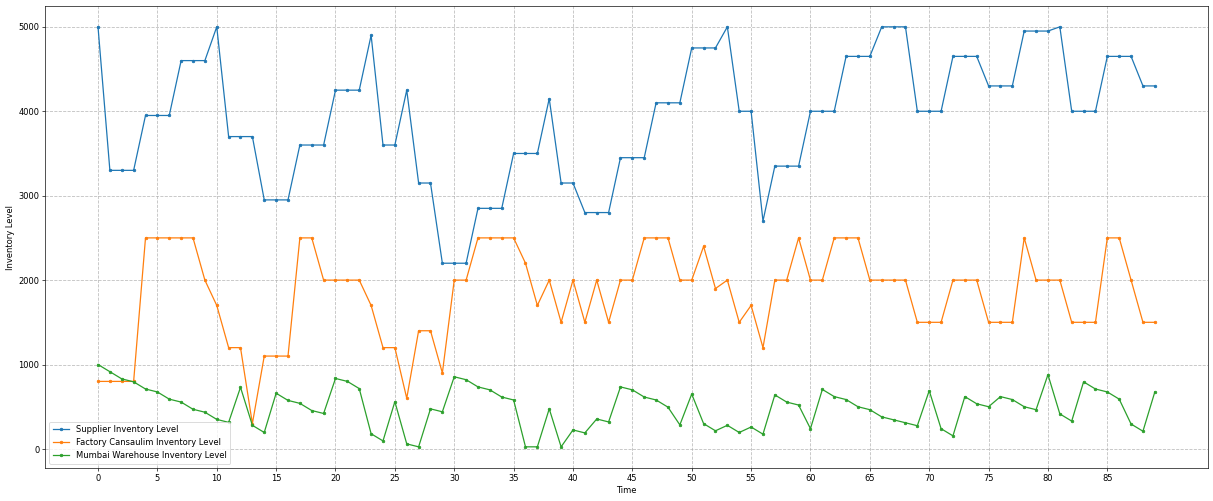

In [2]:
def print_dict(info: dict):
    for key, value in info.items():
        if type(value)==list:
            print(f"\t{key}: {len(value)} (list)")
        else:    
            print(f"\t{key}: {value}")
simtime = 90
env = simpy.Environment()
raw_mat = scm.RawMaterial(ID="RM1", name="raw materials mouse", extraction_quantity=650, 
                          extraction_time=3, mining_cost=0.01, cost=0.1) 
#supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="infinite_supplier", raw_material=raw_mat)
supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="supplier", raw_material=raw_mat, capacity=5000, 
                        initial_level=5000, inventory_holding_cost=0.1)
mouse = scm.Product(ID="MW11", name="Toad M11", manufacturing_cost=10, manufacturing_time=1, sell_price=300, buy_price=150,
                             raw_materials=[{"raw_material": raw_mat, "quantity": 1}], batch_size=2500)
factory = scm.Manufacturer(env=env, ID='F1', name='Factory Cansaulim', capacity=2500, initial_level=800, shelf_life=10,
                           inventory_holding_cost=0.1, replenishment_policy=scm.SSReplenishment, policy_param={'s':1500, 'S':2500}, 
                           product=mouse, product_sell_price=300, inventory_type="perishable")
distributor = scm.InventoryNode(env=env, ID='D1', name='Mumbai Warehouse', node_type="warehouse", shelf_life=10,
                                capacity=1000, initial_level=1000, inventory_holding_cost=0.22,
                                replenishment_policy = scm.RQReplenishment, policy_param={'R':500, 'Q':500}, 
                                product_buy_price=300, product_sell_price=320, inventory_type="perishable")
link = scm.Link(env=env, ID='L1', source=supplier, sink=factory, cost=10, lead_time=lambda: 1)
link = scm.Link(env=env, ID='L1', source=factory, sink=distributor, cost=10, lead_time=lambda: 1)
demand1 = scm.Demand(env=env, ID='demand_D1', name='Demand Pune', order_arrival_model=lambda: 2, order_quantity_model=lambda:50, 
                     delivery_cost=lambda:10, lead_time=lambda:0.9, demand_node=distributor)
demand2 = scm.Demand(env=env, ID='demand_D2', name='Demand Kalyan', order_arrival_model=lambda: 1, order_quantity_model=lambda:35, 
                     delivery_cost=lambda:10, lead_time=lambda:0.9, demand_node=distributor)
#scm.global_logger.disable_logging()
env.run(until=simtime)
from matplotlib.pyplot import figure
figure(figsize=(25, 10), dpi=60)
for node in [supplier, factory, distributor]:
    inv_levels = np.array(node.inventory.instantaneous_levels)
    plt.plot(inv_levels[:,0], inv_levels[:,1], label=f'{node.name} Inventory Level',marker='.')
plt.xlabel('Time')
plt.ylabel('Inventory Level')
xticks = np.arange(0, simtime, 5)
plt.xticks(xticks)
plt.grid(which='both', linestyle='--', linewidth=1, alpha=0.8)
plt.legend()
plt.show()

In [3]:
total_inv_cost = 0
total_transport_cost = 0
for node in [factory, distributor]: #   demand1, demand2
    #print("info_keys = ",node._info_keys)
    #print("stats_keys = ",node._stats_keys)
    print(f"\nname:{node.name}, ID:({node.ID})")
    #print_dict(node.get_info())
    node_stats = node.get_statistics()
    print_dict(node_stats)
    total_inv_cost += node_stats['inventory_cost']
    node_transport_cost = node_stats['transportation_cost']
    total_transport_cost += node_transport_cost

print(f"\nTotal Inventory Holding Cost: {total_inv_cost}")
print(f"Total Transportation Cost: {total_transport_cost}")


name:Factory Cansaulim, ID:(F1)
	node_status: active
	inventory_cost: 18110.0
	transportation_cost: 140
	node_cost: 175250.0
	profit: 150
	revenue: 5010000
	net_profit: 1624750.0
	products_sold: 500
	total_products_sold: 12000
	total_profit: 1800000
	demand_placed: {'S1': [14, 16700]}
	orders_shortage: {}
	total_products_manufactured: 15700
	total_manufacturing_cost: 157000

name:Mumbai Warehouse, ID:(D1)
	node_status: active
	inventory_cost: 9621.699999999999
	transportation_cost: 240
	node_cost: 3609861.7
	profit: 20
	revenue: 3840000
	net_profit: -3505361.7
	products_sold: 35
	total_products_sold: 5225
	total_profit: 104500
	demand_placed: {'F1': [24, 12000]}
	orders_shortage: {}

Total Inventory Holding Cost: 27731.699999999997
Total Transportation Cost: 380
